In [1]:
#Make Mega cut function
import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
from carbon_math import carbon_flux
import xesmf as xe
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
from funcx import cut_aco2, cut_eq_vars, proc_landschutzer, proc_landschutzer_old,cut_sst,cut_regrid_sst
#client = Client()


In [2]:
'''Preprocessing functions - Need to really describe what is going on for each of these.
Possible to combine into a general function that given something like

#(type=[one of bgc, physics, atmos],variable='NAME' (or array NAMES)?, Cut to Troppac? True/False, Need to regrid somehow? RegridMethod, )

Ie given a lon,lat,time,region,fixlongcoords,savepath,startyear,endyear,variablenames,trend?,


Type: BGC, Physics, Atmos
Variable = Either string or array of NAMES


Mean_of_ensemble=True #To Ensemble #0. 
Cut_eqpac= Default True (If False is global)
convert_times=True #Convert to numpy datetime.
fix_long_coords=Default False
StartDay=1982
EndDay=2019-01-01
Trend=False (Calculate per pixel trends)
Unit_fixer=False #Temporary. Maybe build this in later to automatically convert to useful units.
Regridder=False #Temporary. For the moment doesnt matter because we will regrid the other datasets to this one
plot=True #Check that it is what we think.

Tests?


Going to need a few if statements depending on which case is being handled. Start with BGC variables

Another set of questions is. How should this data be stored.

/scratch1/pit071/CAFE60/processed/*

name=Variable_Startday_TropPac_TR?_ENSMEM?
tp
'''

In [15]:
def calc_longterm_trends(ds,startday=np.datetime64('1982-01-01'),endday=np.datetime64('2020-01-01')):
    hovmol=ds
    hovmol=hovmol.where(hovmol!=-0.9999,np.nan)
    hm=hovmol.interpolate_na(dim='time').sel(time=slice(startday,endday))
    months=hm.time

    dt_dates=pd.to_numeric(months.values.astype('datetime64[D]'))
    num_dates=dt_dates
    hm['time']=num_dates

    #This will calculate the per pixel trends and pvalues

    time=hm.time.values
    xx=np.concatenate(hm.T)

    tr=[]
    pv=[]
    
    
    for i in range(xx.shape[0]):
        #Add a bit of logic to mask the arrays and if they are empty just fill it with nans.
        x=xx[i,:]
        y=time

        x=np.ravel(x)
        y=np.ravel(y)
        mask=~np.isnan(x)
        x=x[mask]
        y=y[mask]
        if len(x)!=0:
            stat=linregress(y,x)
            tr.append(stat.slope*365)
            pv.append(stat.pvalue)
        else:
            #Fill that row with nans
            stat=linregress(xx[i,:],time)
            tr.append(stat.slope*365)
            pv.append(stat.pvalue)


    tr=np.array(tr).reshape(len(hm.lon),len(hm.lat)).T
    pv=np.array(pv).reshape(len(hm.lon),len(hm.lat)).T

    hh=hm.copy()
    hh=hh.drop('time')
    hh['trend']=(['lat','lon'],tr)
    hh['pval']=(['lat','lon'],pv)
    return hh

def make_sst_trends_netcdf(modeldata,syear='1982-01-01'):
        ens=[]
        for i in modeldata.ensemble.values:
            print(i)
            model_tr=calc_longterm_trends(modeldata.sel(ensemble=i),syear=syear)
            ens.append(model_tr)

        model_tr=calc_longterm_trends(modeldata.mean(dim='ensemble'),syear=syear)
        ens.append(model_tr)
        trends=xr.concat(ens,dim='ensemble')
        return trends
         
def check_existing_file(spath,force=False):
    '''
    Returns False and deletes file if force is true
    Returns true if the path exists and can open. If corrupt it deletes and returns false.
    '''
    if os.path.isfile(spath)==True:
        if force==True:
            os.remove(spath)
            return False
        else:
            try:
                xr.open_dataset(spath)
                return True
            except:
                os.remove(spath)
                return False
    else:
        return False

In [77]:
def single_line_plotter(lmean,ltrend82,ltrend20,titles,ltrendmm=None,ltrendm=None,l_conversion=1,meancolormap='viridis',figsize=(10,8)):
    
    '''
    lmean     xrarr
    ltrend82  xrarr
    ltrend82p xarr
    ltrend20  xrarr
    ltrend20p pval xarr
    
    rmean     xrarr
    rtrend82  xrarr
    rtrend82p pval xarr
    rtrend20  xrarr 
    rtrend20p pval xarr
    titles    array[1,2,3,4,5,6]
    l_conversion float
    r_conversion float
    meancolormap     str cmap (ie viridis)
    
    Will dynamically produce a 3 x 2 (6) subplot with mean on top and 82 and 2000 trends below. 
    Can produce for any trend variable (produce mean over time, need a flag for this?)
    
    '''
    
    plt.figure(figsize=figsize)
    plt.subplot(311)
    if type(ltrendm)==type(None):
        (lmean.mean(dim='time')*l_conversion).plot(cmap=meancolormap) 
    else:
        (lmean.mean(dim='time')*l_conversion).plot(vmin=ltrendm[1],vmax=ltrendm[0],cmap=meancolormap)
    plt.title(titles[0])
    #(((cafe_co2_mean.stf10.mean(dim='time')/1000)*86400)*-12)
    #plt.title('CAFE ens mean mean CO2 flux out of ocean (gC m2 day)')

    plt.subplot(312)
    if type(ltrendmm)==type(None):
        (ltrend82*l_conversion).plot(cmap='bwr')
    else:
        (ltrend82*l_conversion).plot(vmax=ltrendmm[1],vmin=ltrendmm[0],cmap='bwr')
    plt.title(titles[1])
    #((((cafe_co2_82tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('CAFE CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
    #plt.contourf(cafe_co2_82tr.pval.lon,cafe_co2_82tr.pval.lat,cafe_co2_82tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
 


    plt.subplot(313)
    if type(ltrendmm)==type(None):
        (ltrend20*l_conversion).plot(cmap='bwr')
    else:
        (ltrend20*l_conversion).plot(vmax=ltrendmm[1],vmin=ltrendmm[0],cmap='bwr')
    plt.title(titles[2])
    #((((cafe_co2_20tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('CAFE CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
    #plt.contourf(cafe_co2_20tr.pval.lon,cafe_co2_20tr.pval.lat,cafe_co2_20tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
    #plt.tight_layout()

    plt.tight_layout()
    plt.show()

In [75]:
def CAFE60_eqpac_cutter(modelType='BGC',
                        variable=None,
                        cut_eqpac=True,
                        save_all_data=False,
                        convert_times=True,
                        mean_of_ensemble=True,
                        fix_long_coords=True,
                        trend=False,
                        conversion=None,
                        ensemble_trends=False,
                        startday=1982,
                        endday=2020,
                        unit_fixer=False,
                        regridder=False,
                        plot=True,
                        force=False,
                        savepath='/scratch1/pit071/CAFE60/processed/'):
    
    '''
    A large customisable function to slice the data we want out of the CAFE60 storage.
    Focuses on Monthly data. Could be expanded to process daily but not yet.
    Will not deal with depth (st_ocean variable) very well at the moment.  Could be added later.
    
    Save path  /scratch1/pit071/CAFE60/processed/*
    savename=Variable_Startday_TropPac_TR?_ENSMEM?

    modelType: BGC, Physics, Atmos
    variable = Either string or array of NAMES


    Mean_of_ensemble=True #To Ensemble #0. 
    Cut_eqpac= Default True (If False is global)
    convert_times=True #Convert to numpy datetime.
    fix_long_coords=Default False
    StartDay=1982
    EndDay=2019-01-01
    Trend=False (Calculate per pixel trends)
    Unit_fixer=False #Temporary. Maybe build this in later to automatically convert to useful units.
    Regridder=False #Temporary. For the moment do
    
    Conversion should include a modification to enact on datasets to convert to a desired format. For example *-12 for carbon to grams not moles. and then maybe * or /1000 for g/mg conversions.
    
    '''
    #Load the desired data in
    if modelType=='BGC':
        modeldata_all=xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr',consolidated=True)
    elif modelType=='physics':
        modeldata_all=xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_month.zarr',consolidated=True)
    elif modelType=='atmos':
        modeldata_all=xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/atmos_isobaric_month.zarr',consolidated=True)
    
    #Grab the variable[s] we want.
    if type(variable)==type(None):
        print('No variable given')
        return False
    else:
        #Ok grab the variables out
        if type(variable)!=list:
            #Turn it into a list so we can iterate it
            variable=[variable]
        
        # -----
        #Ok this function loops through here.
        for var in variable:
            print('Starting on Variable: '+var)
            try:
                #This should work with one or more variables but will need to double check this works
                modeldata=modeldata_all[var]
            except:
                print('Incorrect variable given: '+var+ '\n Should be one of:\n'+str(list(modeldata_all.keys())))
                return False
    
            # --------------------------
            #Start modifying model data
            print('Begin Dataset Size: '+str(modeldata.nbytes/1e9) + ' GB')

            modeldata=modeldata.rename({'xt_ocean':'lon','yt_ocean':'lat'})

            if fix_long_coords==True:
                modeldata['lon']=modeldata['lon']+360

            if cut_eqpac==True:
                modeldata=modeldata.sel(lon=slice(120,290),lat=slice(-20,20))
                region_name='eqpac/'
            else:
                region_name='global/'

            if convert_times==True:
                modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
                modeldata=modeldata.sel(time=slice(np.datetime64(str(startday)+'-01-01'),np.datetime64('2020-01-01')))
            else:
                print("Cut times for CF Not Implements. Try convert_times=True")

          
            if save_all_data==True:
                #Save the whole dataset here
                spath=savepath+region_name+str(var)+'_all_'+str(startday)+'.nc'
                if check_existing_file(spath,force)==False: #if it returns true then it exists and can open
                    print('Saving Dataset '+var+', size: '+str(modeldata.nbytes/1e9) + ' GB')
                    modeldata.to_netcdf(spath) 
                else:
                    print('Mean whole '+var+' Dataset already exists')

                
                
            if mean_of_ensemble==True:
                #SAVING ENS MEAN
                spath=savepath+region_name+str(var)+'_ensmean_'+str(startday)+'.nc'

                if check_existing_file(spath,force)==False: #if it returns true then it exists and can open
                    if var=='stf10':
                         modeldata_mean=modeldata.sel(ensemble=1)
                    else:
                        modeldata_mean=modeldata.mean(dim='ensemble')
                    print('Saving Mean Ens Dataset Size: '+str(modeldata_mean.nbytes/1e9) + ' GB')

                    modeldata_mean.to_netcdf(spath) 
                else:
                    print('Mean Ens Dataset already exists: '+spath)


            if trend==True:
                 #REQUIRES mean of ensemble=True
                modeldata_mean=xr.open_dataset(savepath+region_name+str(var)+'_ensmean_'+str(startday)+'.nc')[var]


                spath82=savepath+region_name+str(var)+'_meantrends_'+str(1982)+'.nc'
                spath20=savepath+region_name+str(var)+'_meantrends_'+str(2000)+'.nc'

                if check_existing_file(spath82,force)==False:
                    trend_1982=calc_longterm_trends(modeldata_mean,startday='1982-01-01')
                    trend_1982.to_netcdf(spath82)
                else:
                    print('1982 trend Dataset already exists '+spath82)

                if check_existing_file(spath20,force)==False:
                    trend_2000=calc_longterm_trends(modeldata_mean,startday='2000-01-01')
                    trend_2000.to_netcdf(spath20)
                else:
                    print('2000 trend Dataset already exists: '+spath20)

                if plot==True:
                    lmean=xr.open_dataset(spath)[var]
                    ltrend82=xr.open_dataset(spath82).trend
                    ltrend20=xr.open_dataset(spath20).trend
                    titles=[str(var)+' : mean',
                           str(var)+' : 1982-2020 trend',
                           str(var)+' : 2000-2020 trend']
                    single_line_plotter(lmean,ltrend82,ltrend20,titles)

            if ensemble_trends==True:
                print('Processing individual ensemble trends. Might take a while. Probably recommend only for eqpac')
                if len(startday)==4:
                    startday=str(startday)+'-01-01'
                trends=make_sst_trends_netcdf(modeldata,startday)
                spath=savepath+region_name+str(var)+'_enstrends_'+str(startday)+'.nc'
                remove_existing_file(spath)
                trends.to_netcdf(spath)

   
    

In [162]:
xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/stf10_ensmean_1982.nc').stf10

<xarray.DataArray 'stf10' (time: 456, lat: 300, lon: 360)>
[49248000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon      (lon) float64 80.5 81.5 82.5 83.5 84.5 ... 436.5 437.5 438.5 439.5
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77

In [160]:
ls 

sst_ensmean_1982.nc       stf10_meantrends_2000.nc
sst_meantrends_1982.nc    surface_phy_ensmean_1982.nc
sst_meantrends_2000.nc    surface_phy_meantrends_1982.nc
stf10_ensmean_1982.nc     surface_phy_meantrends_2000.nc
stf10_meantrends_1982.nc


In [163]:
def proc_landschutzer(cuttropics=False,force=False):
    #Load and process landschutzer data
    landschutzer_CO2=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/spco2_MPI-SOM_FFN_v2020.nc')
    landschutzer_CO2= landschutzer_CO2.assign_coords(lon=(landschutzer_CO2.lon % 360)).roll(lon=(landschutzer_CO2.dims['lon']),roll_coords=False).sortby('lon')		#EPIC 1 line fix for the dateline problem.
    #landschutzer_CO2=landschutzer_CO2.sel(lon=slice(120,290),lat=slice(-20,20)).fgco2_smoothed/365 #From per to per day
    landschutzer_CO2=landschutzer_CO2.fgco2_smoothed*12 #to grams
    landschutzer_CO2['time']=landschutzer_CO2['time'].astype('datetime64[M]')

    
    #Regrid
    cafe=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/stf10_ensmean_1982.nc')
    regridder = xe.Regridder(landschutzer_CO2, cafe, 'bilinear',reuse_weights=True)
    landschutzer_CO2=regridder(landschutzer_CO2)
    
    savepath='global'
    if cuttropics==True:
        landschutzer_CO2=landschutzer_CO2.sel(lat=slice(-20,20),lon=slice(120,290))
        savepath='eqpac'
    
    fp='/scratch1/pit071/CAFE60/processed/obs/landshutzer_'+savepath+'_regrid.nc'
    if check_existing_file(fp,force)==False:
        landschutzer_CO2.to_netcdf(fp)
    else:
        print('Not resaving Landshutzer: '+savepath)
        
def cut_regrid_reynolds_sst(cuttropics=False,force=False):
    sst_cafe=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/sst_ensmean_1982.nc').sst
    sst_obs=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/sst.mnmean.nc')
    
    #Apply seamask
    seamask=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/seamask.nc')
    seamask= seamask.assign_coords(lon=(seamask.lon % 360)).roll(lon=(seamask.dims['lon'] // 2),roll_coords=True)
    seamask=seamask.reindex(lat=seamask.lat[::-1])
    
    sst_obs_new=sst_obs.sst.where(seamask.seamask==1,np.nan)
    savepath='global'
    if cuttropics==True:
        sst_obs_new=sst_obs_new.sel(lat=slice(20,-20),lon=slice(120,290))
        savepath='eqpac'
        
    sst_obs_new=sst_obs_new.sel(time=slice('1982-01-01','2019-12-01'))
    sst_obs_new=sst_obs_new.reindex(lat=sst_obs.lat[::-1])
    regridder = xe.Regridder(sst_obs_new, sst_cafe, 'bilinear',reuse_weights=True)
    sst_obs_regrid=regridder(sst_obs_new)

    #Could add global if statement here.
    #sst_obs_regrid.to_netcdf('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.nc')
    if check_existing_file('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.'+savepath+'.nc',force)==False:
        print('saving: /scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.'+savepath+'.nc')
        sst_obs_regrid.to_netcdf('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.'+savepath+'.nc')
    else:
        print('Not resaving Reynolds SST'+savepath)
  

In [131]:
def cut_process_sst_obs_trends(force=False):
    paths=['global','eqpac']
    for path in paths:
        fp='/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.'+path+'.nc'
        
        if check_existing_file(fp,force)==True:
            sst_obs=xr.open_dataset(fp)

            sst_obs_tr_1982=calc_longterm_trends(sst_obs.sst,'1982')
            sst_obs_tr_2000=calc_longterm_trends(sst_obs.sst,'2000')

            fp82='/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.'+str(path)+'.trend.1982.nc'
            if check_existing_file(fp82,force)==False:   
                print('saving 82 sst trends')
                sst_obs_tr_1982.to_netcdf(fp82)
            fp20='/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.'+str(path)+'.trend.2000.nc'
            if check_existing_file(fp20,force)==False:
                print('saving 2000 sst trends')
                sst_obs_tr_2000.to_netcdf(fp20)

    
def process_co2_land_trends(force=False):
    paths=['global','eqpac']
    for path in paths:
        fp='/scratch1/pit071/CAFE60/processed/obs/landshutzer_'+path+'_regrid.nc'
         
        if check_existing_file(fp)==True:

            land_obs=xr.open_dataset(fp)
            land_obs_tr_1982=calc_longterm_trends(land_obs.fgco2_smoothed/365,'1982')
            land_obs_tr_2000=calc_longterm_trends(land_obs.fgco2_smoothed/365,'2000')
            
            if check_existing_file('/scratch1/pit071/CAFE60/processed/obs/landshutzer_'+path+'_regrid_trend_1982.nc',force)==False:
                land_obs_tr_1982.to_netcdf('/scratch1/pit071/CAFE60/processed/obs/landshutzer_'+path+'_regrid_trend_1982.nc')
                
            
            if check_existing_file('/scratch1/pit071/CAFE60/processed/obs/landshutzer_'+path+'_regrid_trend_2000.nc',force)==False:
                land_obs_tr_2000.to_netcdf('/scratch1/pit071/CAFE60/processed/obs/landshutzer_'+path+'_regrid_trend_2000.nc')

   

In [11]:
def calc_longterm_trends(ds,startday=np.datetime64('1982-01-01'),endday=np.datetime64('2020-01-01')):
    hovmol=ds
    hovmol=hovmol.where(hovmol!=-0.9999,np.nan)
    hm=hovmol.interpolate_na(dim='time').sel(time=slice(startday,endday))
    months=hm.time

    dt_dates=pd.to_numeric(months.values.astype('datetime64[D]'))
    num_dates=dt_dates
    hm['time']=num_dates

    #This will calculate the per pixel trends and pvalues

    time=hm.time.values
    xx=np.concatenate(hm.T)

    tr=[]
    pv=[]
    
    
    for i in range(xx.shape[0]):
        #Add a bit of logic to mask the arrays and if they are empty just fill it with nans.
        x=xx[i,:]
        y=time

        x=np.ravel(x)
        y=np.ravel(y)
        mask=~np.isnan(x)
        x=x[mask]
        y=y[mask]
        if len(x)!=0:
            stat=linregress(y,x)
            tr.append(stat.slope*365)
            pv.append(stat.pvalue)
        else:
            #Fill that row with nans
            stat=linregress(xx[i,:],time)
            tr.append(stat.slope*365)
            pv.append(stat.pvalue)


    tr=np.array(tr).reshape(len(hm.lon),len(hm.lat)).T
    pv=np.array(pv).reshape(len(hm.lon),len(hm.lat)).T

    hh=hm.copy()
    hh=hh.drop('time')
    hh['trend']=(['lat','lon'],tr)
    hh['pval']=(['lat','lon'],pv)
    return hh


In [197]:
land_obs=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid.nc')

In [376]:
#https://github.com/pydata/xarray/issues/1815
#https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset

#This was just a test function to assess vectorised vs unvectorised version. This version takes approximately the same time as the looped version. 
#Going to ignore this method.

def lin_wrapper(obj,startyear=1982):
    def new_linregress(x, y):
        # Wrapper around scipy linregress to use in apply_ufunc
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        #print(slope)
        return np.array([slope*365, p_value])

    obj=obj.where(obj!=-0.9999,np.nan)
    obj=obj.interpolate_na(dim='time').sel(time=slice(str(startyear)+'-01-01','2020-01-01'))
    obj['time']=pd.to_numeric(obj.time.values.astype('datetime64[D]'))
    
    stat = xr.apply_ufunc(new_linregress, obj['time'], obj,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[['stats']],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"stats": 2})
    return stat

In [377]:
#%%timeit
lin_wrapper(land_obs.fgco2_smoothed/365,startyear=1982)

<ipython-input-376-4a0d79ba016d>:15: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(new_linregress, obj['time'], obj,


<xarray.DataArray (lat: 300, lon: 360, stats: 2)>
array([[[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
...
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        ...,
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]]])
Coordinates:
  * lon      (lon) float64 80.5 81.5 82.5 83.5 84.5 ... 436.5 437.5 438.5 439.5
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
Dimensions without coordinates: stats

In [362]:
%%timeit
calc_longterm_trends(land_obs.fgco2_smoothed/365,startday='1982-01-01')

31.6 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [378]:
#haha so the vectorised version is 1 second faster...  Not worth it!

In [ ]:
#https://stackoverflow.com/questions/48898319/finding-the-indices-of-multiple-items-in-a-list-using-a-list/48898363

In [ ]:
#Code Starts here!

Starting on Variable: sst
Begin Dataset Size: 29.85984 GB
Mean Ens Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/sst_ensmean_1982.nc
1982 trend Dataset already exists /scratch1/pit071/CAFE60/processed/eqpac/sst_meantrends_1982.nc
2000 trend Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/sst_meantrends_2000.nc


<ipython-input-75-199d6115922a>:87: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


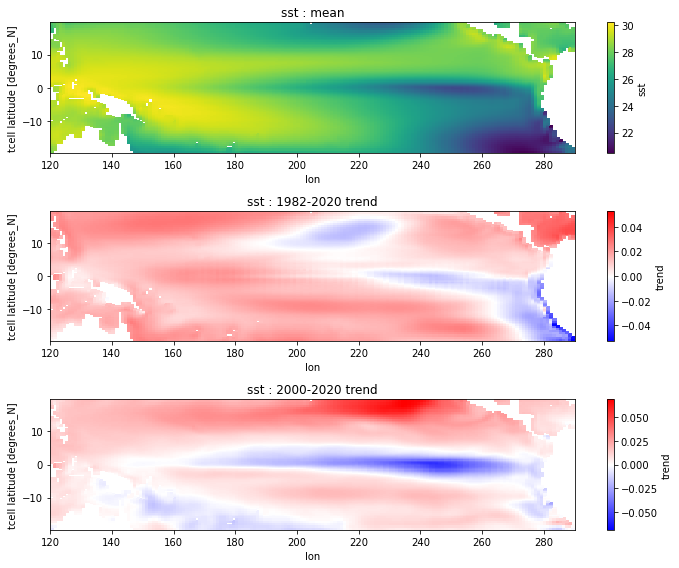

In [81]:
"""
BGC
surface_phy
pprod_gross_2d
export_prod
export_inorg
surface_dic
surface_zoo
"""
#['stf10','surface_phy']
CAFE60_eqpac_cutter(modelType='physics',
                        variable='sst',
                        cut_eqpac=True,
                        save_all_data=False,
                        trend=True,
                        force=False)

Starting on Variable: stf10
Begin Dataset Size: 29.85984 GB
Mean Ens Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/stf10_ensmean_1982.nc
1982 trend Dataset already exists /scratch1/pit071/CAFE60/processed/eqpac/stf10_meantrends_1982.nc
2000 trend Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/stf10_meantrends_2000.nc


<ipython-input-75-199d6115922a>:87: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


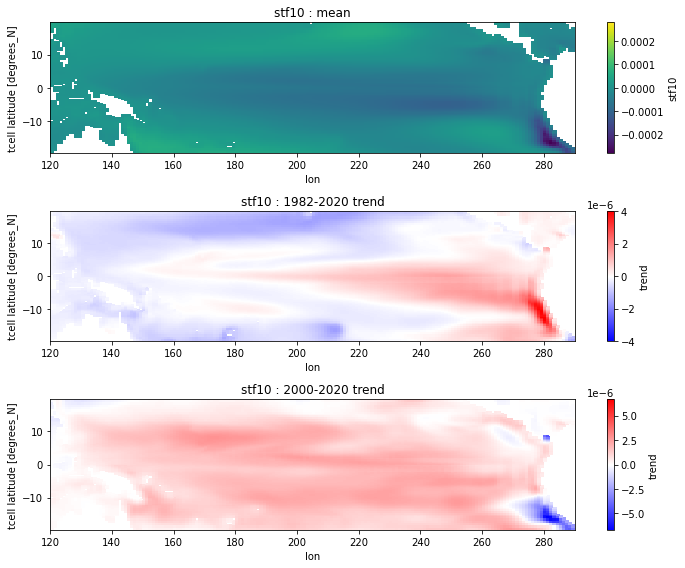

Starting on Variable: pprod_gross_2d
Begin Dataset Size: 29.85984 GB
Mean Ens Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/pprod_gross_2d_ensmean_1982.nc
1982 trend Dataset already exists /scratch1/pit071/CAFE60/processed/eqpac/pprod_gross_2d_meantrends_1982.nc
2000 trend Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/pprod_gross_2d_meantrends_2000.nc


<ipython-input-75-199d6115922a>:87: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


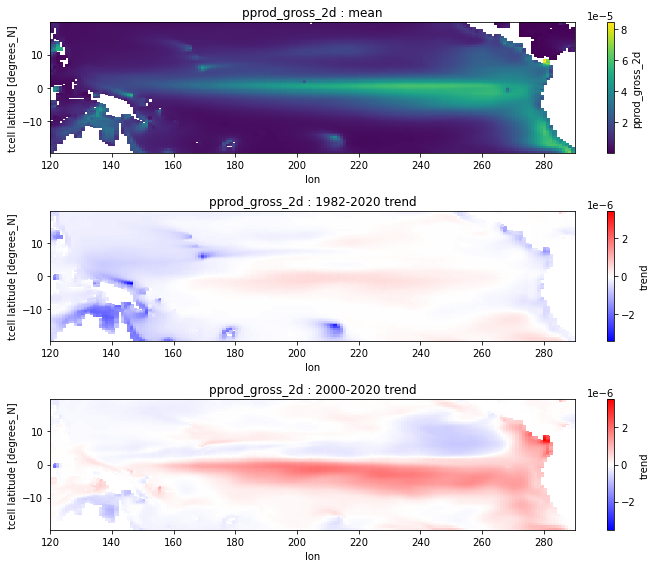

Starting on Variable: export_prod
Begin Dataset Size: 29.85984 GB
Mean Ens Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/export_prod_ensmean_1982.nc
1982 trend Dataset already exists /scratch1/pit071/CAFE60/processed/eqpac/export_prod_meantrends_1982.nc
2000 trend Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/export_prod_meantrends_2000.nc


<ipython-input-75-199d6115922a>:87: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


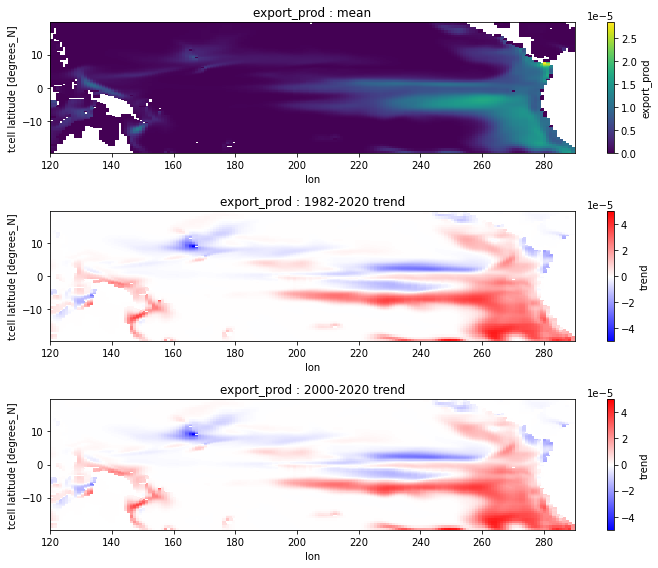

Starting on Variable: surface_zoo
Begin Dataset Size: 29.85984 GB
Mean Ens Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/surface_zoo_ensmean_1982.nc
1982 trend Dataset already exists /scratch1/pit071/CAFE60/processed/eqpac/surface_zoo_meantrends_1982.nc
2000 trend Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/surface_zoo_meantrends_2000.nc


<ipython-input-75-199d6115922a>:87: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


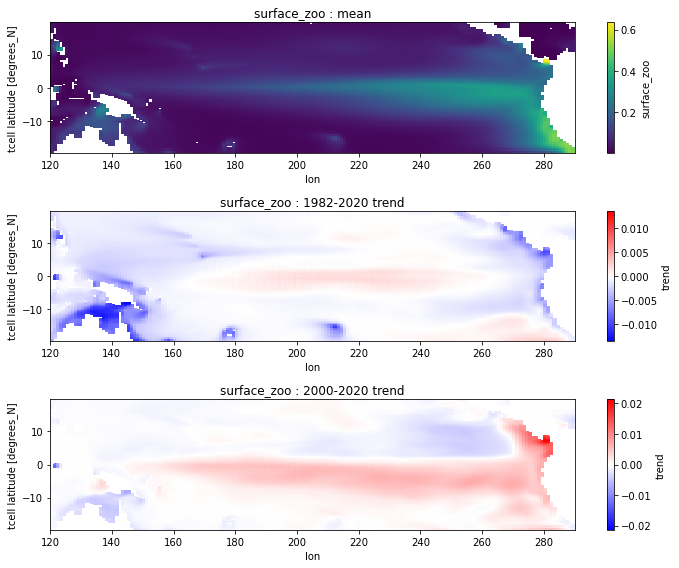

Starting on Variable: surface_dic
Begin Dataset Size: 29.85984 GB
Mean Ens Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/surface_dic_ensmean_1982.nc
1982 trend Dataset already exists /scratch1/pit071/CAFE60/processed/eqpac/surface_dic_meantrends_1982.nc
2000 trend Dataset already exists: /scratch1/pit071/CAFE60/processed/eqpac/surface_dic_meantrends_2000.nc


<ipython-input-75-199d6115922a>:87: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


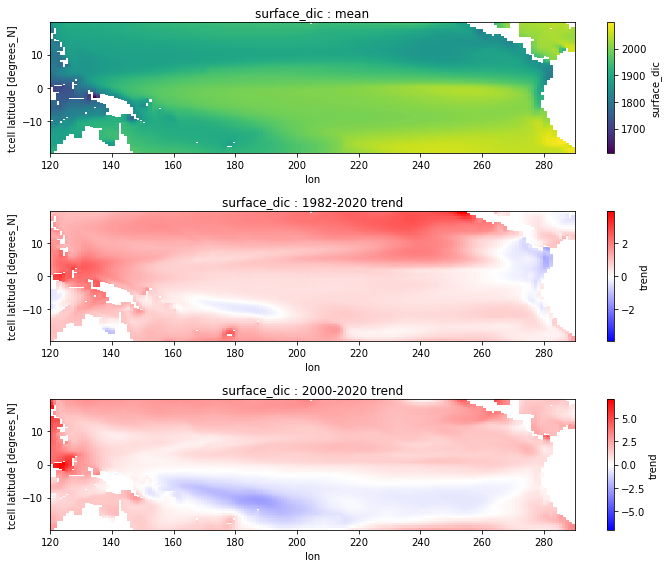

In [79]:
CAFE60_eqpac_cutter(modelType='BGC',
                        variable=['stf10','pprod_gross_2d','export_prod','surface_zoo','surface_dic'],
                        cut_eqpac=True,
                        save_all_data=False,
                        trend=True,
                        force=False)

Starting on Variable: stf10
Begin Dataset Size: 29.85984 GB
Saving Dataset stf10, size: 2.91723264 GB


<ipython-input-75-199d6115922a>:87: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


Saving Mean Ens Dataset Size: 0.03038784 GB


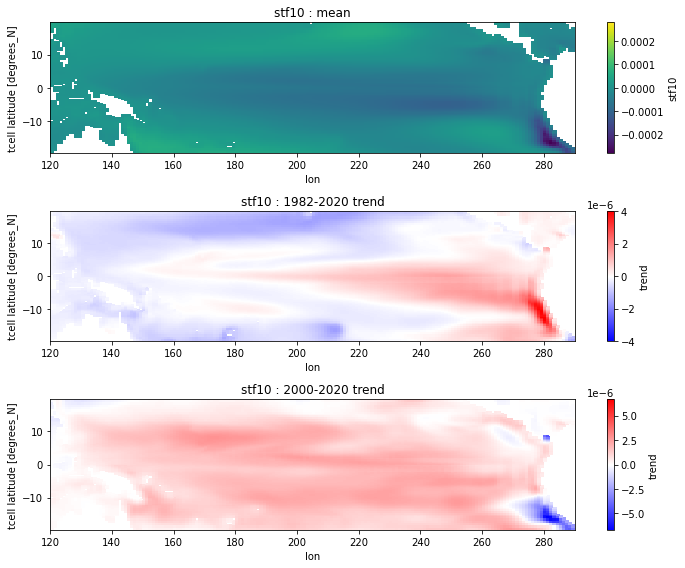

In [133]:
CAFE60_eqpac_cutter(modelType='BGC',
                        variable=['stf10'],
                        cut_eqpac=True,
                        save_all_data=True,
                        trend=True,
                        force=True,
                        plot=True)

In [103]:
#Cut out global and eqpac reynolds SST and calculate trends for them. Saved in /scratch1/pit071/CAFE60/processed/obs/
cut_regrid_reynolds_sst(True,True) #Cut eqpac SST,force (If force=True will delete any existing file and resave)
cut_regrid_reynolds_sst(False,True) #Cut global SST and force save 
cut_process_sst_obs_trends(True) #Force trends for both global and eqpac. Should do both eqpac and global.  

Reuse existing file: bilinear_180x170_300x360.nc


/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/xesmf/frontend.py:412: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


saving: /scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.eqpac.nc
Reuse existing file: bilinear_180x360_300x360.nc


/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/xesmf/frontend.py:412: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


saving: /scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.global.nc
saving 82 sst trends
saving 2000 sst trends
saving 82 sst trends
saving 2000 sst trends


In [164]:
#Basically the same as above but for landshutzer.
#proc_landschutzer(False,True)
proc_landschutzer(True,True)
process_co2_land_trends(True)

Reuse existing file: bilinear_180x360_300x360.nc


/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/xesmf/frontend.py:412: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


In [62]:
#Attempting a plotting function
def mean_trends_82_20(lmean,ltrend82,ltrend20,rmean,rtrend82,rtrend20,titles,ltrendmm=None,rtrendmm=None,ltrendm=None,rtrendm=None,l_conversion=1,r_conversion=1,meancolormap='bwr',figsize=(20,10)):
    '''
    lmean     xrarr
    ltrend82  xrarr
    ltrend82p xarr
    ltrend20  xrarr
    ltrend20p pval xarr
    
    rmean     xrarr
    rtrend82  xrarr
    rtrend82p pval xarr
    rtrend20  xrarr 
    rtrend20p pval xarr
    titles    array[1,2,3,4,5,6]
    l_conversion float
    r_conversion float
    meancolormap     str cmap (ie viridis)
    
    Will dynamically produce a 3 x 2 (6) subplot with mean on top and 82 and 2000 trends below. 
    Can produce for any trend variable (produce mean over time, need a flag for this?)
    
    '''
    
    plt.figure(figsize=figsize)
    plt.subplot(321)
    if type(ltrendm)==type(None):
        (lmean.mean(dim='time')*l_conversion).plot(cmap=meancolormap) 
    else:
        (lmean.mean(dim='time')*l_conversion).plot(vmin=ltrendm[1],vmax=ltrendm[0],cmap=meancolormap)
    plt.title(titles[0])
    #(((cafe_co2_mean.stf10.mean(dim='time')/1000)*86400)*-12)
    #plt.title('CAFE ens mean mean CO2 flux out of ocean (gC m2 day)')

    plt.subplot(322)
    if type(ltrendm)==type(None):
        (rmean.mean(dim='time')*r_conversion).plot(cmap=meancolormap) 
    else:
        (rmean.mean(dim='time')*r_conversion).plot(vmin=rtrendm[1],vmax=rtrendm[0],cmap=meancolormap)
    plt.title(titles[1])
    #(land_obs.fgco2_smoothed/365).mean(dim='time').plot(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('Lanschutzer mean CO2 flux out of ocean (gC m2 day)')

    plt.subplot(323)
    if type(ltrendmm)==type(None):
        (ltrend82*l_conversion).plot(cmap='bwr')
    else:
        (ltrend82*l_conversion).plot(vmax=ltrendmm[1],vmin=ltrendmm[0],cmap='bwr')
    plt.title(titles[2])
    #((((cafe_co2_82tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('CAFE CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
    #plt.contourf(cafe_co2_82tr.pval.lon,cafe_co2_82tr.pval.lat,cafe_co2_82tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
 


    plt.subplot(324)
    if type(rtrendmm)==type(None):
        (rtrend82*r_conversion).plot(cmap='bwr')
    
    else:
        (rtrend82*r_conversion).plot(vmax=rtrendmm[1],vmin=rtrendmm[0],cmap='bwr')
    plt.title(titles[3])
    #((land_obs_tr_1982.trend)*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('Landshutzer CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
    #plt.contourf(land_obs_tr_1982.pval.lon,land_obs_tr_1982.pval.lat,land_obs_tr_1982.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   


    plt.subplot(325)
    if type(ltrendmm)==type(None):
        (ltrend20*l_conversion).plot(cmap='bwr')
    else:
        (ltrend20*l_conversion).plot(vmax=ltrendmm[1],vmin=ltrendmm[0],cmap='bwr')
    plt.title(titles[4])
    #((((cafe_co2_20tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('CAFE CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
    #plt.contourf(cafe_co2_20tr.pval.lon,cafe_co2_20tr.pval.lat,cafe_co2_20tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
    #plt.tight_layout()


    plt.subplot(326)
    if type(rtrendmm)==type(None):
        (rtrend20*r_conversion).plot(cmap='bwr')
    else:
        (rtrend20*r_conversion).plot(vmax=rtrendmm[1],vmin=rtrendmm[0],cmap='bwr')
    plt.title(titles[5])
    #((land_obs_tr_2000.trend)*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('Landshutzer CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
    #plt.contourf(land_obs_tr_2000.pval.lon,land_obs_tr_2000.pval.lat,land_obs_tr_2000.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
    plt.tight_layout()
    plt.show()

In [60]:
phy_mean=xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/surface_phy_ensmean_1982.nc')
phy_trend82=xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/surface_phy_meantrends_1982.nc')
phy_trend20=xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/surface_phy_meantrends_2000.nc')
pprod_mean=xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/pprod_gross_2d_ensmean_1982.nc')
pprod_trend82=xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/pprod_gross_2d_meantrends_1982.nc')
pprod_trend20=xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/pprod_gross_2d_meantrends_2000.nc')

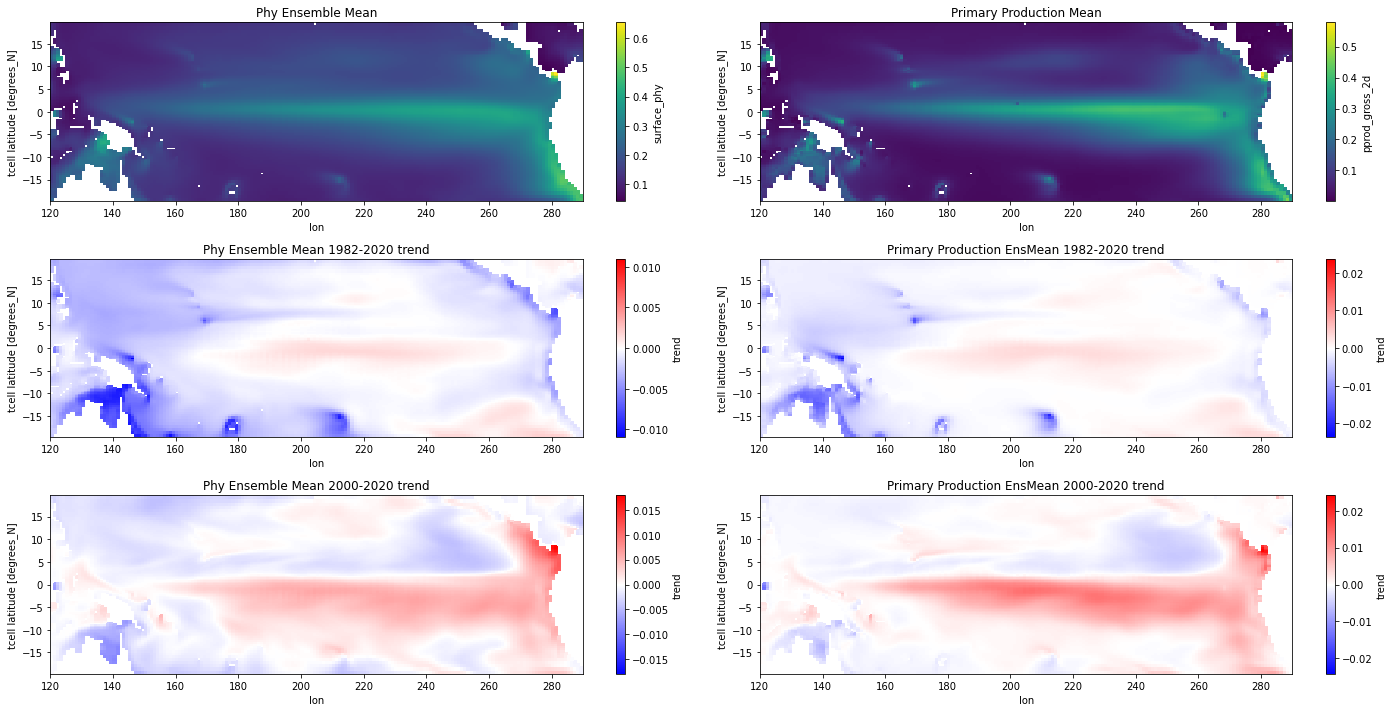

In [65]:
#Test the plotting function. Not super easy to use to be honest. 
titles=[
    'Phy Ensemble Mean',
    'Primary Production Mean',
    'Phy Ensemble Mean 1982-2020 trend',
    'Primary Production EnsMean 1982-2020 trend',
    'Phy Ensemble Mean 2000-2020 trend',
    'Primary Production EnsMean 2000-2020 trend']



mean_trends_82_20(lmean=phy_mean.surface_phy,
                  ltrend82=phy_trend82.trend,
                  ltrend20=phy_trend20.trend,
                  rmean=pprod_mean.pprod_gross_2d,
                  rtrend82=pprod_trend82.trend,
                  rtrend20=pprod_trend20.trend,
                  titles=titles,
                  ltrendmm=None,
                  rtrendmm=None,
                  ltrendm=None,
                  rtrendm=None,
                  l_conversion=1,
                  r_conversion=6.625*12*86400/1000,
                  meancolormap='viridis',
                  figsize=(20,10))

In [26]:
#LOAD CAFE SST AND CO2 FLUX
cafe_sst_mean=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/sst_ensmean_1982.nc')
cafe_sst_82tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/sst_meantrends_1982.nc')
cafe_sst_20tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/sst_meantrends_2000.nc')

cafe_co2_mean=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/stf10_ensmean_1982.nc')
cafe_co2_82tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/stf10_meantrends_1982.nc')
cafe_co2_20tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/stf10_meantrends_2000.nc')

In [126]:
#Load CO2 and SST OBS PRODUCTS
land_co2=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid.nc')
land_co2_82tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid_trend_1982.nc')
land_co2_20tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid_trend_2000.nc')

rey_sst=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.global.nc')
rey_sst_82tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.global.trend.1982.nc')
rey_sst_20tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.global.trend.2000.nc')

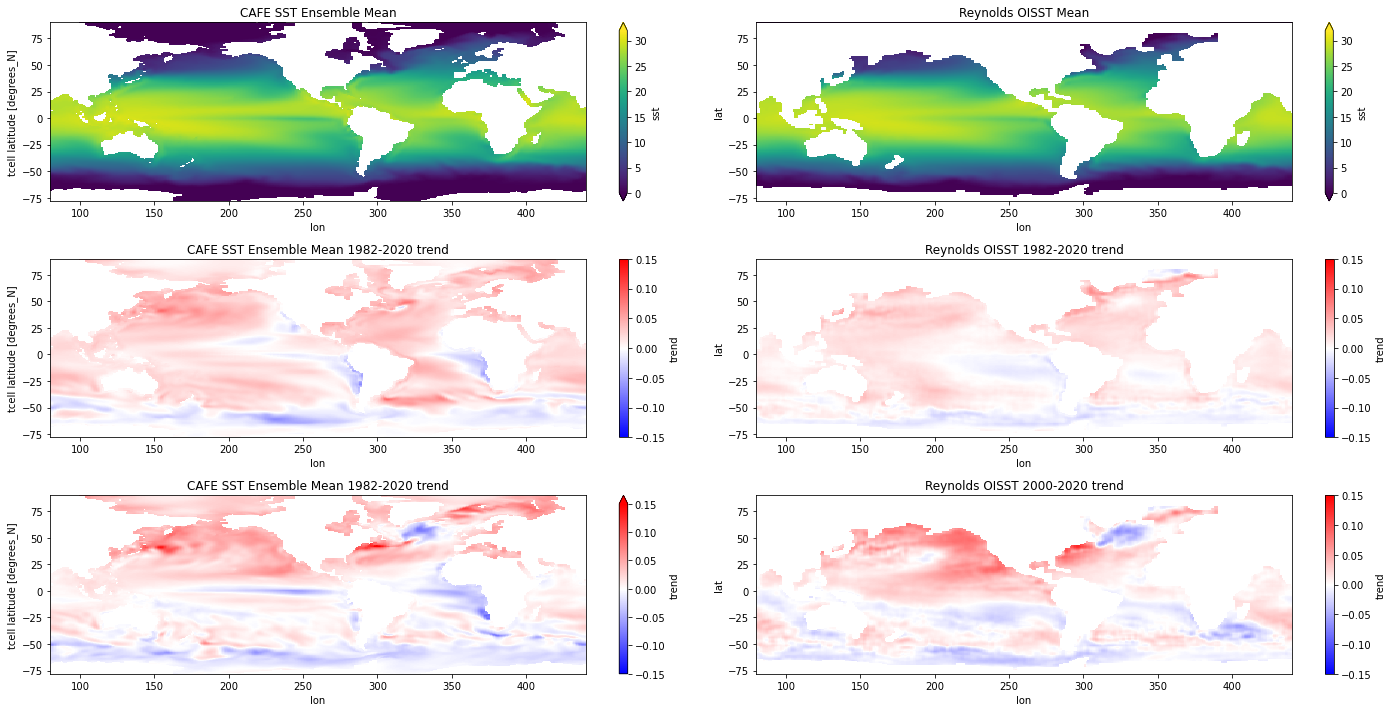

In [127]:
titles=[
    'CAFE SST Ensemble Mean',
    'Reynolds OISST Mean',
    'CAFE SST Ensemble Mean 1982-2020 trend',
    'Reynolds OISST 1982-2020 trend',
    'CAFE SST Ensemble Mean 1982-2020 trend',
    'Reynolds OISST 2000-2020 trend']

mean_trends_82_20(cafe_sst_mean.sst,cafe_sst_82tr.trend,cafe_sst_20tr.trend,rey_sst.sst,rey_sst_82tr.trend,rey_sst_20tr.trend,titles,[-0.15,0.15],[-0.15,0.15],[0,32],[0,32],1,1,'viridis')

In [116]:
def diff_plot(a,b,title):
    (a-b).plot()
    plt.title(title)
    #plt.show()
    

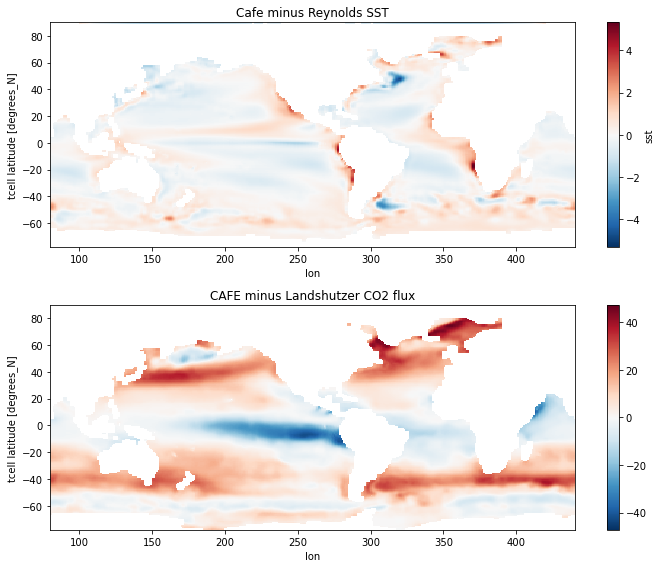

In [128]:
plt.figure(figsize=(10,8))
plt.subplot(211)
diff_plot(cafe_sst_mean.sst.mean(dim='time'),rey_sst.sst.mean(dim='time'),'Cafe minus Reynolds SST')

plt.subplot(212)
diff_plot(cafe_co2_mean.stf10.mean(dim='time'),land_co2.fgco2_smoothed.mean(dim='time'),'CAFE minus Landshutzer CO2 flux')
plt.tight_layout()

In [119]:
land_co2_

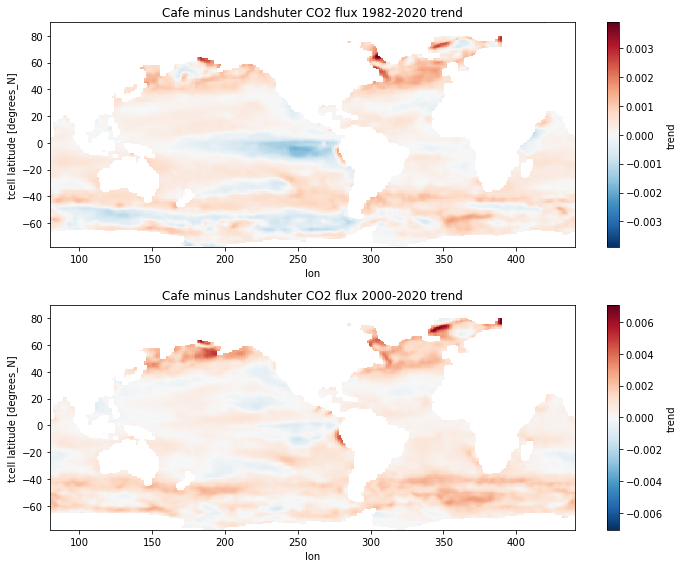

In [123]:
plt.figure(figsize=(10,8))
plt.subplot(211)
diff_plot(cafe_co2_82tr.trend,land_co2_82tr.trend,'Cafe minus Landshuter CO2 flux 1982-2020 trend')

plt.subplot(212)
diff_plot(cafe_co2_20tr.trend,land_co2_20tr.trend,'Cafe minus Landshuter CO2 flux 2000-2020 trend')
plt.tight_layout()

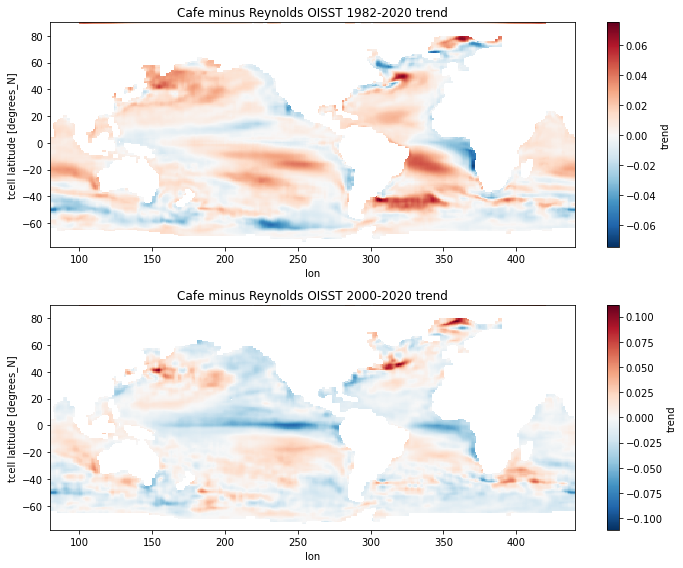

In [130]:
plt.figure(figsize=(10,8))
plt.subplot(211)
diff_plot(cafe_sst_82tr.trend,rey_sst_82tr.trend,'Cafe minus Reynolds OISST 1982-2020 trend')

plt.subplot(212)
diff_plot(cafe_sst_20tr.trend,rey_sst_20tr.trend,'Cafe minus Reynolds OISST 2000-2020 trend')
plt.tight_layout()

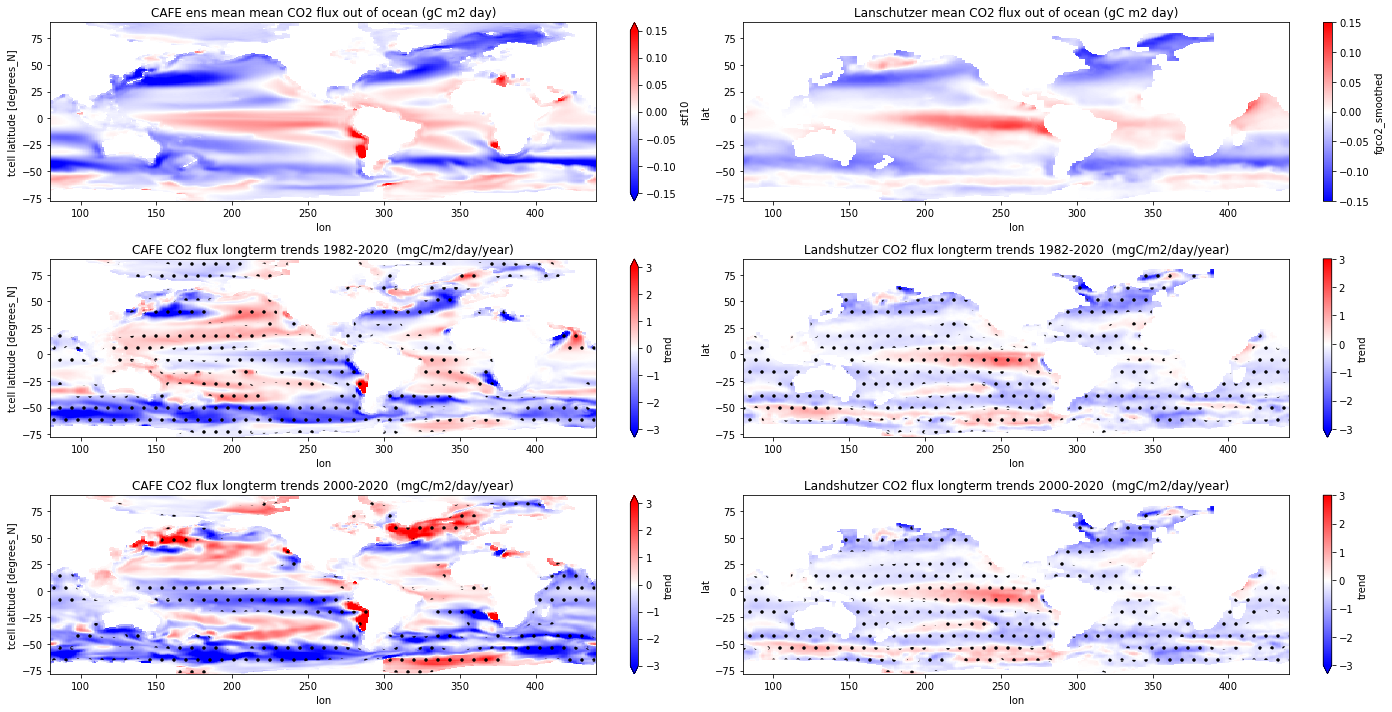

In [5]:
#CO2 FLUX mean and trends
plt.figure(figsize=(20,10))
plt.subplot(321)

(((cafe_co2_mean.stf10.mean(dim='time')/1000)*86400)*-12).plot(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE ens mean mean CO2 flux out of ocean (gC m2 day)')

plt.subplot(322)
(land_obs.fgco2_smoothed/365).mean(dim='time').plot(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Lanschutzer mean CO2 flux out of ocean (gC m2 day)')

plt.subplot(323)
((((cafe_co2_82tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
plt.contourf(cafe_co2_82tr.pval.lon,cafe_co2_82tr.pval.lat,cafe_co2_82tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(324)
((land_obs_tr_1982.trend)*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Landshutzer CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
plt.contourf(land_obs_tr_1982.pval.lon,land_obs_tr_1982.pval.lat,land_obs_tr_1982.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(325)
((((cafe_co2_20tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
plt.contourf(cafe_co2_20tr.pval.lon,cafe_co2_20tr.pval.lat,cafe_co2_20tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(326)
((land_obs_tr_2000.trend)*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Landshutzer CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
plt.contourf(land_obs_tr_2000.pval.lon,land_obs_tr_2000.pval.lat,land_obs_tr_2000.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


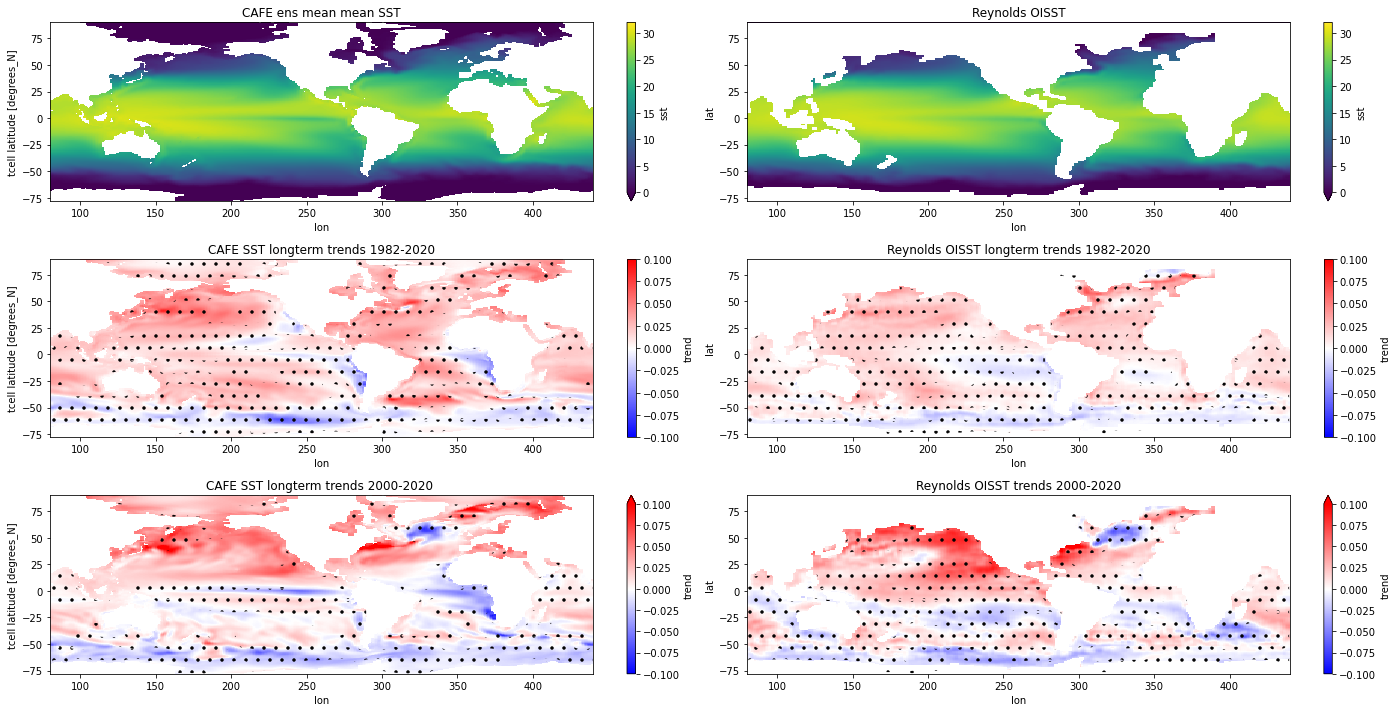

In [112]:
#SST mean and trends
plt.figure(figsize=(20,10))
plt.subplot(321)

(((cafe_sst_mean.sst.mean(dim='time')))).plot(vmin=0,vmax=32)
plt.title('CAFE ens mean mean SST')

plt.subplot(322)
(sst_rey_obs.sst).mean(dim='time').plot(vmin=0,vmax=32)
plt.title('Reynolds OISST')

plt.subplot(323)
((((cafe_sst_82tr.trend)))).plot(vmax=0.1,vmin=-0.1,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE SST longterm trends 1982-2020')
plt.contourf(cafe_co2_82tr.pval.lon,cafe_co2_82tr.pval.lat,cafe_co2_82tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   

plt.subplot(324)
((sst_obs_tr_1982.trend)).plot(vmax=0.1,vmin=-0.1,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Reynolds OISST longterm trends 1982-2020')
plt.contourf(land_obs_tr_1982.pval.lon,land_obs_tr_1982.pval.lat,land_obs_tr_1982.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   


plt.subplot(325)
((((cafe_sst_20tr.trend)))).plot(vmax=0.1,vmin=-0.1,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE SST longterm trends 2000-2020 ')
plt.contourf(cafe_co2_20tr.pval.lon,cafe_co2_20tr.pval.lat,cafe_co2_20tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   


plt.subplot(326)
((sst_obs_tr_2000.trend)).plot(vmax=0.1,vmin=-0.1,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Reynolds OISST trends 2000-2020')
plt.contourf(land_obs_tr_2000.pval.lon,land_obs_tr_2000.pval.lat,land_obs_tr_2000.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()

In [104]:
modeldata_all=xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_month.zarr',consolidated=True)

In [49]:
#Ok lets test some of these datasets.
#surface_phy_meantrends_1982.nc
#188M	./stf10_ensmean_1982.nc
#190M	./stf10_meantrends_1982.nc
#101M	./surface_phy_meantrends_2000.nc
#18G	./stf10_all_1982.nc
#18G	./surface_phy_all_1982.nc
#188M	./surface_phy_ensmean_1982.nc
#101M	./stf10_meantrends_2000.nc

#/scratch1/pit071/CAFE60/processed/global

In [83]:
fp='/scratch1/pit071/CAFE60/processed/global/'
stf10_ensmean_1982=xr.open_dataset(fp+'stf10_ensmean_1982.nc')
stf10_mean_trends_1982=xr.open_dataset(fp+'stf10_meantrends_1982.nc')


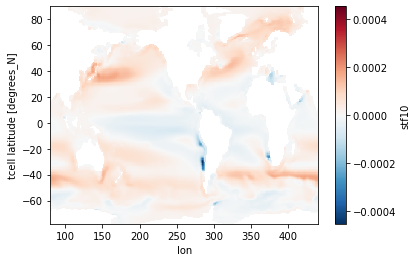

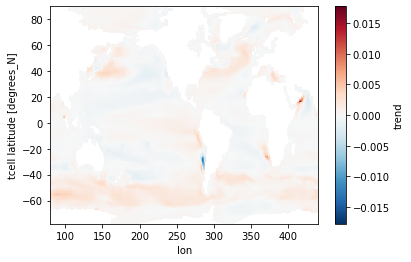

In [87]:
stf10_ensmean_1982.stf10.mean(dim='time').plot(),plt.show()
(stf10_mean_trends_1982.trend*1000).plot()

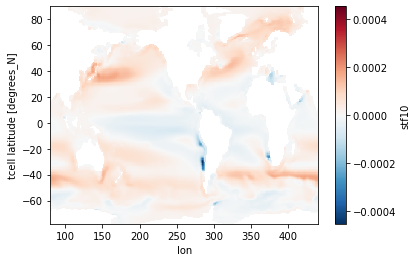

In [82]:
stf10_ensmean_1982.stf10.mean(dim='time').plot()

In [49]:
dat=xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/stf10_meantrends_2000.nc')

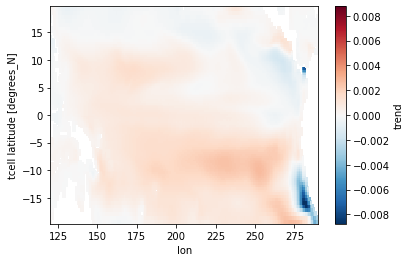

In [53]:
(dat.trend*1000).plot()

In [3]:
land_co2_pac

<xarray.DataArray 'fgco2_smoothed' (time: 456, lat: 98, lon: 170)>
[7596960 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
Attributes:
    regrid_method:  bilinear

In [17]:
land_co2_pac=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/landshutzer_eqpac_regrid.nc').fgco2_smoothed/365

In [18]:
cafe_co2_pac=((xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/stf10_all_1982.nc')/1000)*86400)*-12

In [175]:
cafe_co2_std

Whole EqPac : -32.11635964264057% err
SouthEast EqPac : 108.94881562333059% err
NorthEast EqPac : -30.70658609534077% err
All East EqPac : -5.589238200070874% err
Central EqPac : -2.4949648548318923% err
Dateline EqPac : 6.923204962253075% err
FarWest EqPac : -44.45912427470231% err


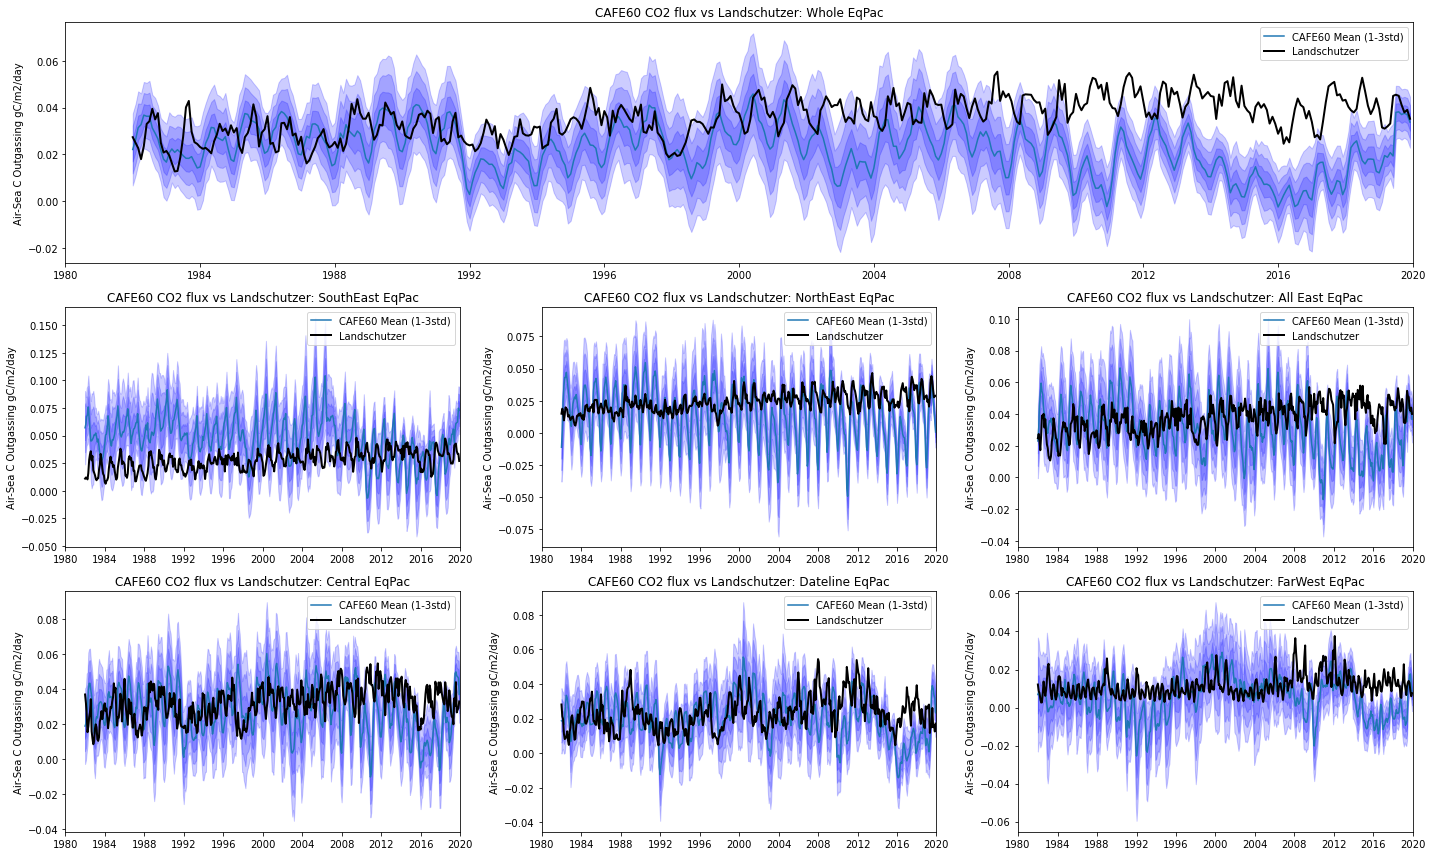

<xarray.Dataset>
Dimensions:      (ensemble: 96, region: 7)
Coordinates:
  * ensemble     (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
  * region       (region) int64 0 1 2 3 4 5 6
Data variables:
    percenterr   (region, ensemble) float64 -10.34 -12.49 ... -17.51 -28.37
    bias         (region, ensemble) float64 -0.005173 -0.006821 ... -0.004431
    mae          (region, ensemble) float64 0.01146 0.01315 ... 0.01021 0.01001
    region_name  (region) <U15 'Whole EqPac' ... 'FarWest EqPac'


In [19]:
#Ok first big plot. Regionality to look at the timeseries and see how they perform

labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

all_err=[]
for i,latlon in enumerate(locs):
    cafe_co2_std=cafe_co2_pac.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    cafe_co2_mean=cafe_co2_pac.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    land_co2_std=land_co2_pac.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    land_co2_mean=land_co2_pac.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])

    err=cafe_co2_mean.std(dim='ensemble')
    m=cafe_co2_mean.mean(dim='ensemble')
    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
    ax.plot(m.time,m.stf10)
    ax.fill_between(err.time.values,m.stf10+(err*1).stf10,m.stf10-(err*1).stf10,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.stf10+(err*2).stf10,m.stf10-(err*2).stf10,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.stf10+(err*3).stf10,m.stf10-(err*3).stf10,alpha=0.2,color='blue')

    ax.plot(land_co2_mean.time,land_co2_mean,c='k',linewidth=2)
    ax.legend(['CAFE60 Mean (1-3std)','Landschutzer'])
    ax.set_xlim(['1980-01-01','2020-01-01'])
    ax.set_ylabel('Air-Sea C Outgassing gC/m2/day')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title('CAFE60 CO2 flux vs Landschutzer: '+labels[i])

    
    #Calculate biases
    
    #These biases might be backwards.
    perc_err=(((cafe_co2_mean.stf10-land_co2_mean)/land_co2_mean)*100).mean(dim='time')
    bias=(cafe_co2_mean.stf10-land_co2_mean).mean(dim='time')
    mae=np.abs(cafe_co2_mean.stf10-land_co2_mean).mean(dim='time')
    print(labels[i]+' : '+str(perc_err.mean(dim='ensemble').values) + '% err')
    perc_err.name='percenterr'
    bias.name='bias'
    mae.name='mae'
    err_stats=xr.merge([perc_err,bias,mae],compat='override')
    err_stats['region']=i
    err_stats['region_name']=labels[i]
    all_err.append(err_stats)
    
regional_err=xr.concat(all_err,dim='region')
regional_err.to_netcdf('/scratch1/pit071/CO2_flux_error.nc')
plt.tight_layout()
plt.show()
print(regional_err)

In [25]:
land_co2_std

<xarray.DataArray 'fgco2_smoothed' (time: 456)>
array([0.01210199, 0.00858607, 0.00770338, 0.00487333, 0.0026259 ,
       0.00269892, 0.00737723, 0.01366016, 0.00951064, 0.00615246,
       0.00906925, 0.01439624, 0.02140406, 0.02301836, 0.01673005,
       0.01054229, 0.00666978, 0.00434827, 0.00959999, 0.01225246,
       0.01073817, 0.00597344, 0.00415128, 0.0063657 , 0.01121532,
       0.01626028, 0.01651841, 0.01594836, 0.01033539, 0.00624521,
       0.01023416, 0.00836234, 0.00822173, 0.00747312, 0.00571643,
       0.0052497 , 0.00784666, 0.01314734, 0.01014345, 0.00640371,
       0.00503437, 0.0048406 , 0.00819849, 0.01150893, 0.00811534,
       0.00434223, 0.00402642, 0.00623403, 0.01197562, 0.01180179,
       0.01241425, 0.00616999, 0.00459386, 0.00546111, 0.00926297,
       0.01092621, 0.01018835, 0.0069352 , 0.00522769, 0.00938728,
       0.01276356, 0.01474531, 0.01123509, 0.00816651, 0.00450667,
       0.00431354, 0.00982869, 0.01041613, 0.0104757 , 0.00726524,
       0.00602363, 0.00434979, 0.01036723, 0.01080287, 0.01399509,
       0.00800269, 0.00829763, 0.00667616, 0.01050414, 0.01154611,
       0.01250577, 0.0117819 , 0.02041655, 0.01794131, 0.02584501,
       0.01878769, 0.01507583, 0.01068678, 0.0089701 , 0.0067359 ,
       0.00983109, 0.00881898, 0.00688924, 0.00626842, 0.00554058,
       0.00474844, 0.01066342, 0.01262178, 0.00909341, 0.00410804,
...
       0.02544771, 0.03758947, 0.02526793, 0.01249032, 0.01178993,
       0.01158179, 0.01575594, 0.01453625, 0.01102604, 0.00725351,
       0.00644493, 0.00870092, 0.01469695, 0.02518931, 0.02266583,
       0.01715229, 0.01327856, 0.01174342, 0.01983492, 0.01552076,
       0.01634298, 0.00893007, 0.00829776, 0.0135056 , 0.01653084,
       0.01354273, 0.01320507, 0.00989977, 0.00752473, 0.01027185,
       0.01666919, 0.01517029, 0.01233395, 0.00728861, 0.00541044,
       0.00642426, 0.01100666, 0.0119677 , 0.01959534, 0.01063396,
       0.0118246 , 0.01376617, 0.0157029 , 0.01437855, 0.01019271,
       0.01039987, 0.00356566, 0.00779643, 0.01292491, 0.01776965,
       0.01039181, 0.01067828, 0.00619245, 0.00805745, 0.013408  ,
       0.01412447, 0.01315499, 0.00889413, 0.00833715, 0.01130311,
       0.01658179, 0.02017466, 0.0176284 , 0.01354095, 0.01174302,
       0.01153327, 0.01860116, 0.01321821, 0.01582715, 0.01116039,
       0.00853593, 0.01270484, 0.01928308, 0.02085999, 0.01551803,
       0.01253035, 0.0112615 , 0.01149935, 0.01458664, 0.01108773,
       0.01144777, 0.00546542, 0.00506428, 0.01108983, 0.01439424,
       0.02276029, 0.01335126, 0.00968164, 0.00654016, 0.01127295,
       0.0131775 , 0.01398494, 0.0129006 , 0.00870814, 0.00592593,
       0.00753521])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01

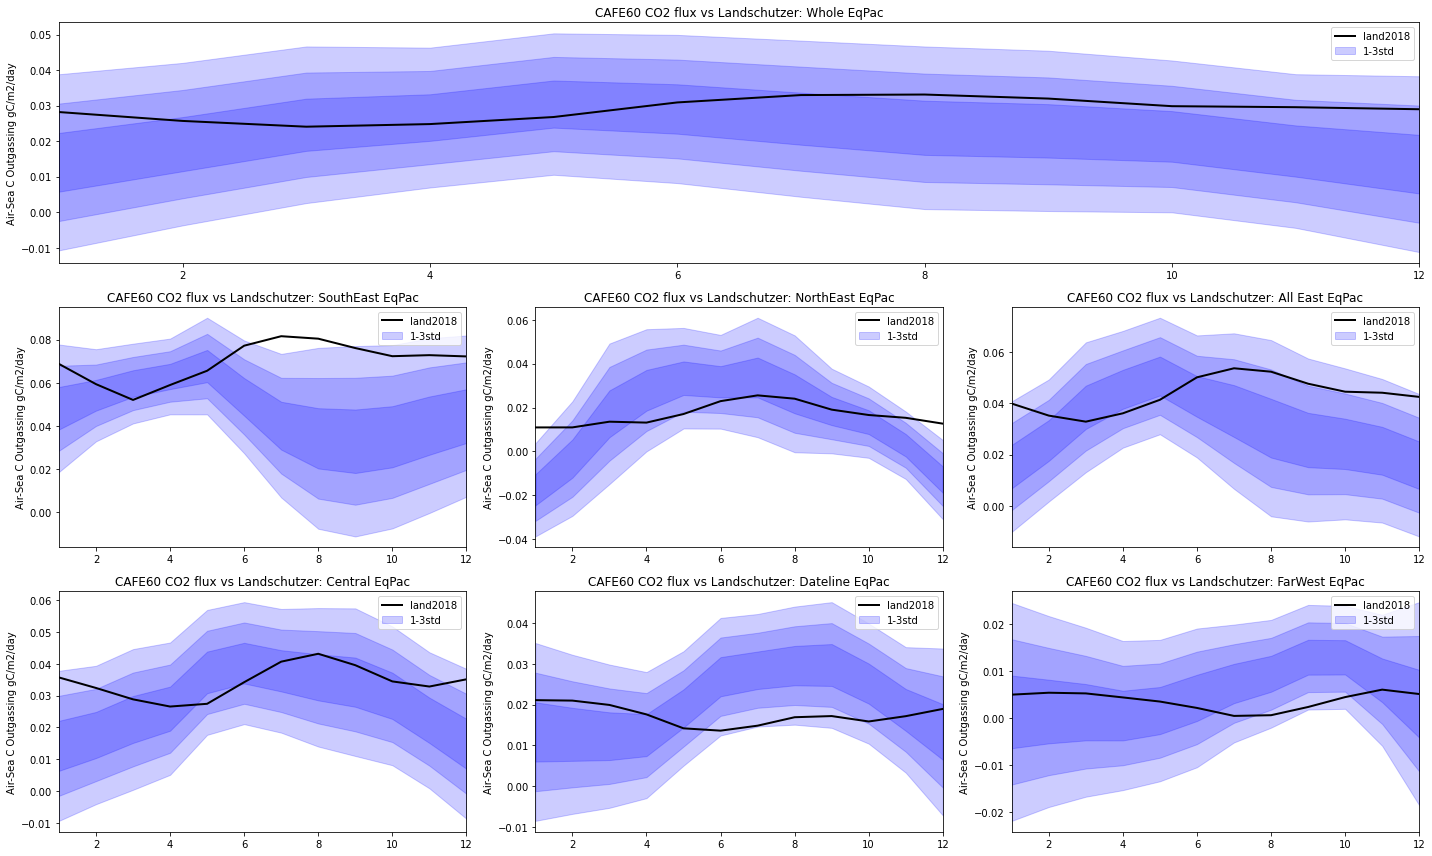

In [27]:
#They don't line up very well so lets check the seasonality

labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

for i,latlon in enumerate(locs):
    cafe_seasonality=cafe_co2_pac.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).stf10.groupby('time.month').mean()
 
    land_seasonality=land_co2_pac.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).groupby('time.month').mean().mean(dim=['lat','lon'])
 

    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
        
    err=cafe_seasonality.std(dim='ensemble').mean(dim=['lat','lon'])
    m=cafe_seasonality.mean(['lat','lon','ensemble'])
    
    ax.fill_between(err.month,m+(err*1),m-(err*1),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*2),m-(err*2),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*3),m-(err*3),alpha=0.2,color='blue')
    

    ax.plot(land_seasonality.month,land_seasonality,c='k',linewidth=2)
   
    #olc=old_land_clim.fgco2_clim.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    #olc['monthclim']=olc['monthclim']+1
    #ax.plot(olc.monthclim,olc,c='k',linewidth=2,linestyle='--')
    
    #Ok we could plot the individual lines using seaborn. 
    
    #land_seasonality=land_seasonality.to_dataframe().reset_index()
    #seasonal=cafe_seasonality.stf10.mean(dim=['lat','lon']).to_dataframe().reset_index()
    
    #sns.lineplot(data=seasonal,x='month',y='stf10',hue='ensemble',ax=ax)#,hue='ensemble')
    #sns.lineplot(data=land_seasonality,x='month',y='fgco2_smoothed',color='k',linewidth=3,ax=ax)#,hue='ensemble')
        
        
    ax.set_xlim([1,12])
    ax.set_ylabel('Air-Sea C Outgassing gC/m2/day')
    ax.set_title('CAFE60 CO2 flux vs Landschutzer: '+labels[i])
    ax.legend(['land2018','1-3std'])
plt.tight_layout()

    
  
    